In [1]:
from dsd import DATA_DIR 

render_dataset = DATA_DIR / "diffusion_renders" / "mugs" / "run_3"
sam_csv_path = render_dataset / "sam_IoUs.csv"
clip_score_csv_path = "clip_scores.csv"

In [2]:
import pandas 

sam_df = pandas.read_csv(render_dataset / sam_csv_path).drop(columns=["Unnamed: 0"])
clip_df = pandas.read_csv(render_dataset / clip_score_csv_path).drop(columns=["Unnamed: 0"])


In [3]:
df_list = []
for path in sam_df["relative_path"]:
    key = path.split(".png")[0]
    prompt = key.split("/")[-1].split("_")[0]
    renderer = key.split("/")[-2]
    mesh = key.split("/")[-4]
    original_render_id = key.split("/")[-3]
    relative_image_path =  str(path)

    # add entry to dataframe
    df_list.append([renderer, prompt, mesh, original_render_id,relative_image_path])


In [4]:
df = pandas.DataFrame(df_list, columns=["renderer", "prompt", "mesh", "original_render_id", "relative_path"])
df = df.merge(sam_df, on="relative_path")
df = df.merge(clip_df, on="relative_path",how="left")
df_w_original = df.copy()
df_original_indices = [i for i in range(len(df)) if "original" in df["relative_path"].iloc[i]]
df = df.drop(index=df_original_indices)

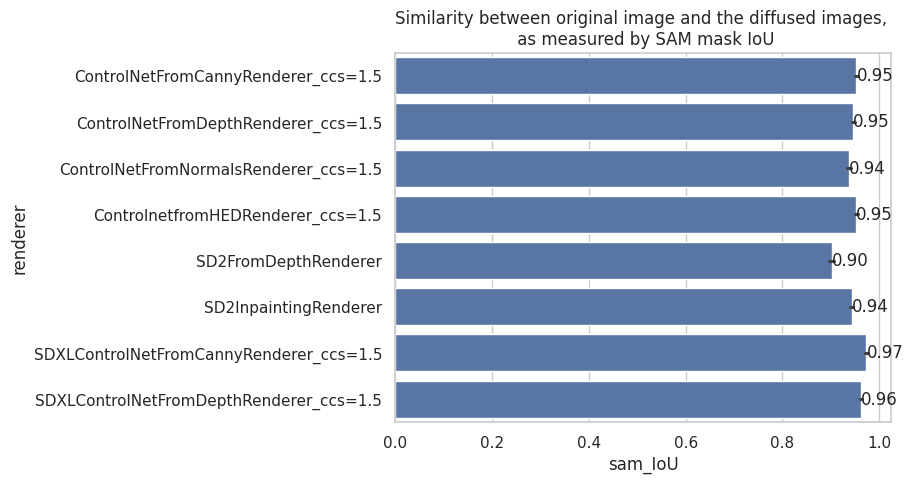

In [5]:
# plot the sam similarity for each renderer
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme(style="whitegrid")

# sort the barplot by the mean value
ax = sns.barplot(y="renderer", x="sam_IoU", data=df,order=sorted(df['renderer'].unique()))
ax.bar_label(ax.containers[0], fmt='%.2f', label_type='edge')
plt.title("Similarity between original image and the diffused images, \n as measured by SAM mask IoU")
plt.show()

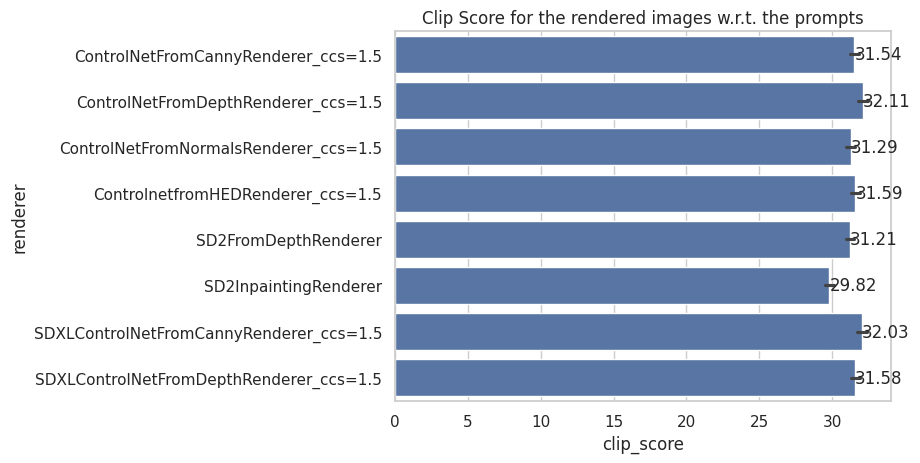

In [6]:
# plot the clip Score for each renderer
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme(style="whitegrid")

# sort the barplot by the mean value
ax = sns.barplot(y="renderer", x="clip_score", data=df,order=sorted(df['renderer'].unique()))
ax.bar_label(ax.containers[0], fmt='%.2f', label_type='edge')
plt.title("Clip Score for the rendered images w.r.t. the prompts")
plt.show()

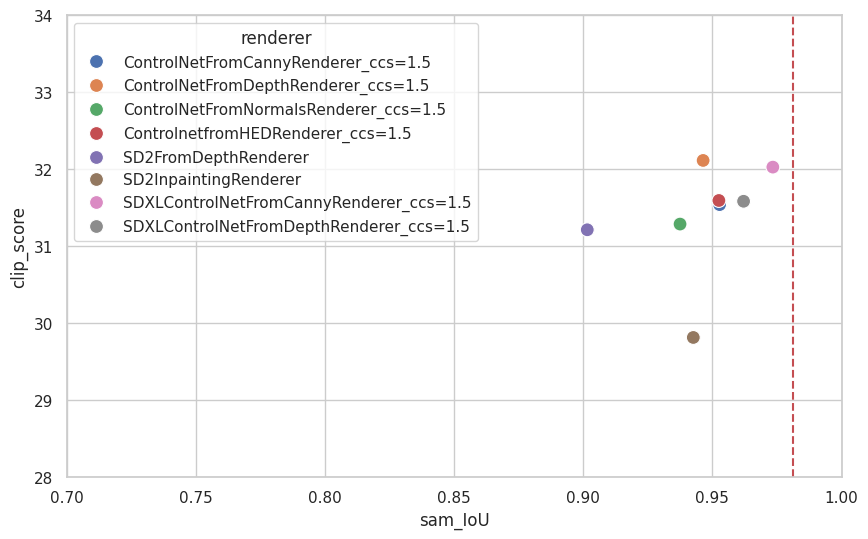

In [7]:
sns.set_theme(style="whitegrid")

# sort the barplot by the mean value
df_grouped_by_renderer = df.groupby("renderer").mean(numeric_only=True)
df_original_grouped_by_renderer = df_w_original.groupby("renderer").mean(numeric_only=True)
plt.figure(figsize=(10, 6))
p1= sns.scatterplot(data=df_grouped_by_renderer, x="sam_IoU", y="clip_score", hue=df_grouped_by_renderer.index, s=100)
# set x range
p1.set_xlim(0.7, 1)
# set y range
p1.set_ylim(28,34)

# vertical line on original renderer mean sam_IoU
p1.axvline(df_original_grouped_by_renderer.sam_IoU["original"], color='r', linestyle='--', label="GT IoU")

# for line in range(0,df_grouped_by_renderer.shape[0]):
#      p1.text(df_grouped_by_renderer.sam_IoU[line]+0.001, df_grouped_by_renderer.clip_score[line], 
#      df_grouped_by_renderer.index[line], horizontalalignment='left', 
#      size='small', color='black')

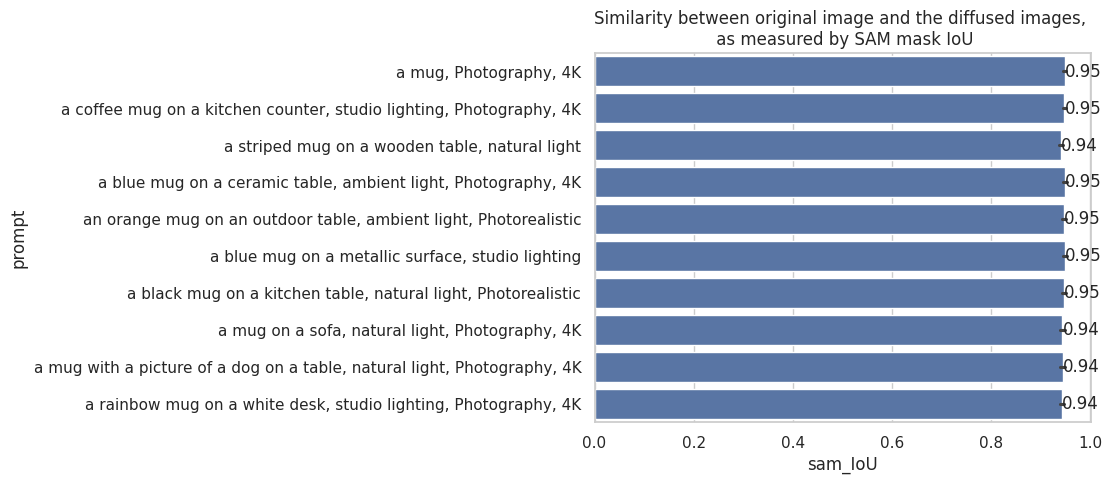

In [8]:
ax = sns.barplot(x="sam_IoU", y="prompt", data=df)
ax.bar_label(ax.containers[0], fmt='%.2f', label_type='edge')
plt.title("Similarity between original image and the diffused images, \n as measured by SAM mask IoU")
plt.show()

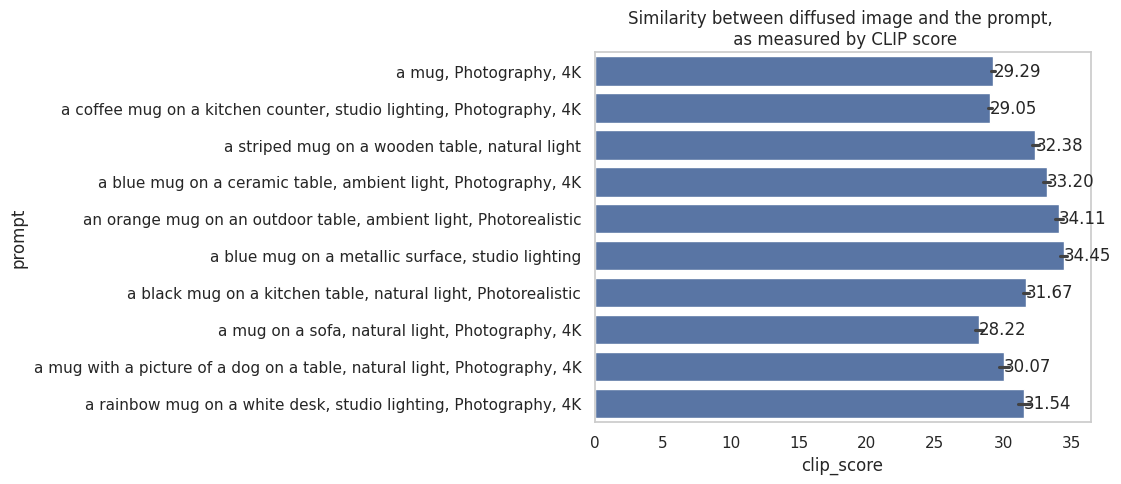

In [9]:
ax = sns.barplot(x="clip_score", y="prompt", data=df)
# drop grid
ax.grid(False)
ax.bar_label(ax.containers[0], fmt='%.2f', label_type='edge')
plt.title("Similarity between diffused image and the prompt, \n as measured by CLIP score")
plt.show()

In [10]:
# group by the combination of mesh and render_id
# create new column that combines mesh and render_id
df["mesh_render_id"] = df["mesh"] + "_" + df["original_render_id"]
# group by this new column
df_grouped = df.groupby("mesh_render_id").mean(numeric_only=True)
df_grouped

# only get the N best and worst
N = 5
df_grouped = df_grouped.sort_values(by="sam_IoU")
df_grouped_best = df_grouped[-N:]
df_grouped_worst = df_grouped[:N]

df_grouped_extremes = pandas.concat([df_grouped_best, df_grouped_worst])

Text(0.5, 1.0, 'Histogram of average similarities for the original images, \n averaged over all prompts and diffusion renderers')

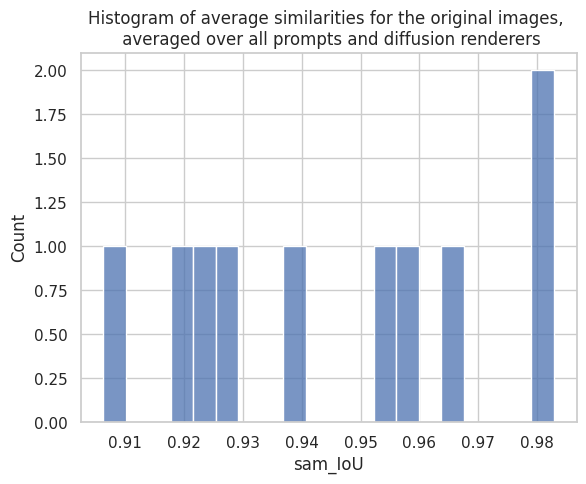

In [11]:
sns.set_theme(style="whitegrid")
ax = sns.histplot(x="sam_IoU",data=df_grouped, bins=20)
plt.title("Histogram of average similarities for the original images, \n averaged over all prompts and diffusion renderers")

Text(0.5, 1.0, 'Similarity between original image and the diffused images for the five best and worst images')

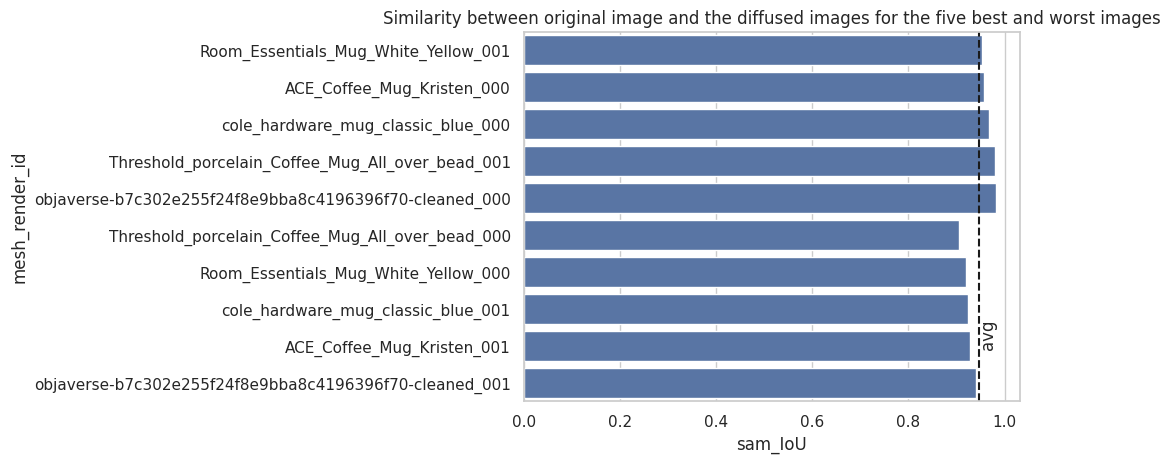

In [12]:
# plot the sam similarity for each
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme(style="whitegrid")
# show the distribution of sam mask IoU for each mesh
ax = sns.barplot(x="sam_IoU", y="mesh_render_id", data=df_grouped_extremes)
# draw vertical line for the average
plt.axvline(x=df_grouped["sam_IoU"].mean(), color='k', linestyle='--')
# add label to the vertical line
plt.text(df_grouped["sam_IoU"].mean(), 8, "avg", rotation=90)
plt.title("Similarity between original image and the diffused images for the five best and worst images")


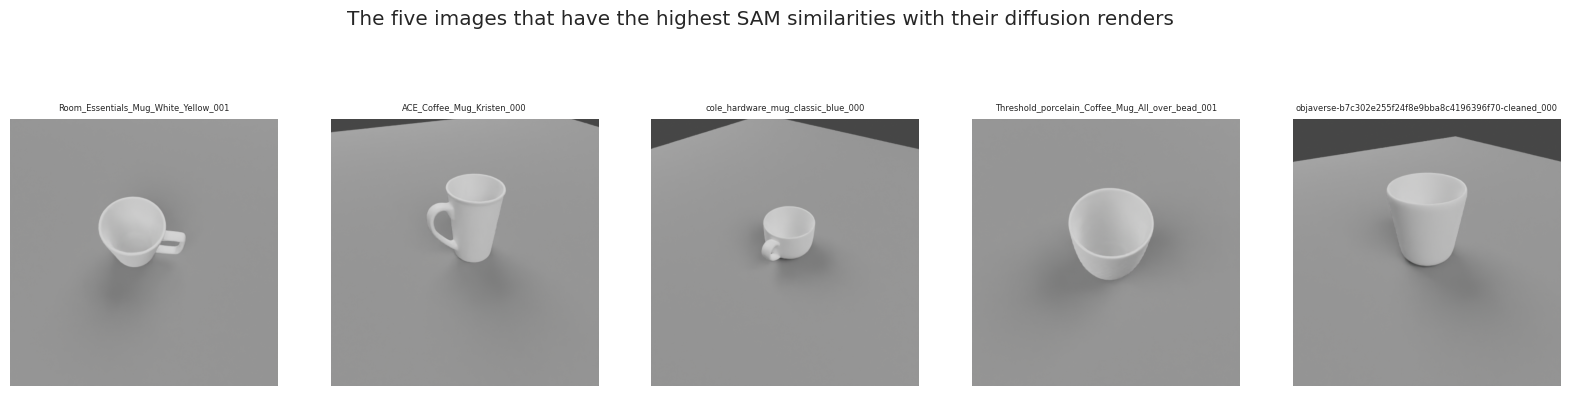

In [13]:
# show the five best rgb images
import matplotlib.pyplot as plt
from PIL import Image
fig, axes = plt.subplots(1, N, figsize=(20, 5))


for i, row in enumerate(df_grouped_best.iterrows()):
    mesh_render_id = row[0]
    relative_image_path = df[df["mesh_render_id"] == mesh_render_id]["relative_path"].iloc[0]
    image_path = render_dataset / relative_image_path
    original_image_path = image_path.parents[1] / "original" / "rgb.png"
    image = Image.open(original_image_path)
    axes[i].imshow(image)
    axes[i].set_title(row[0], fontsize=6)
    axes[i].axis("off")

plt.suptitle("The five images that have the highest SAM similarities with their diffusion renders")
plt.show()


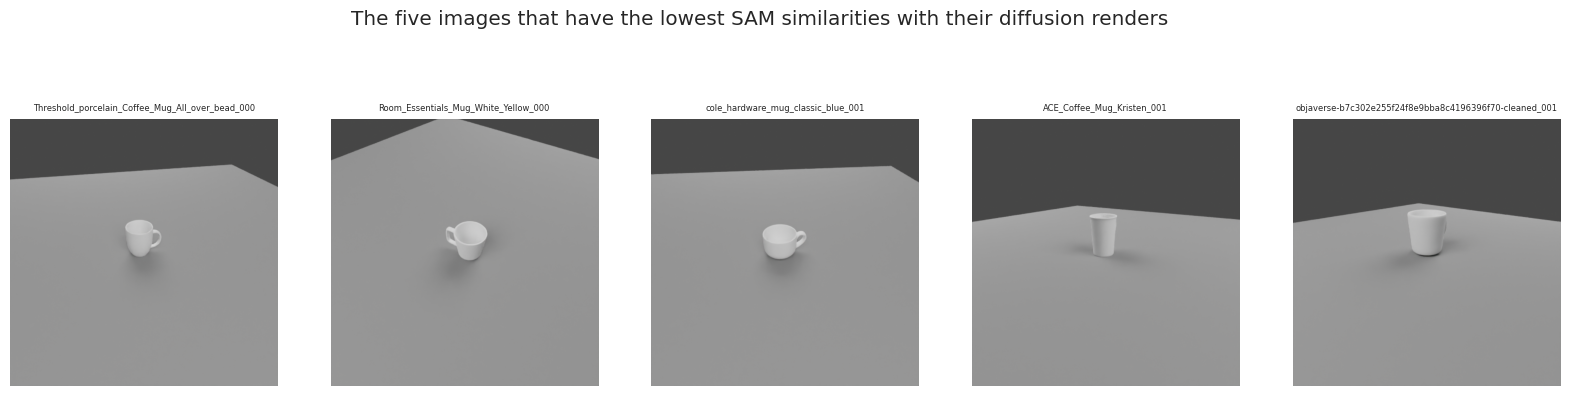

In [14]:
# show the five worst rgb images
import matplotlib.pyplot as plt
from PIL import Image
fig, axes = plt.subplots(1, N, figsize=(20, 5))
for i, row in enumerate(df_grouped_worst.iterrows()):
    mesh_render_id = row[0]
    relative_image_path = df[df["mesh_render_id"] == mesh_render_id]["relative_path"].iloc[0]
    image_path = render_dataset / relative_image_path
    original_image_path = image_path.parents[1] / "original" / "rgb.png"
    image = Image.open(original_image_path)
    axes[i].imshow(image)
    axes[i].set_title(row[0], fontsize=6)
    axes[i].axis("off")

plt.suptitle("The five images that have the lowest SAM similarities with their diffusion renders")

plt.show()